
# Special Topics in Astrodynamics | ae4889

## Time-series prediction on a simple function

#### Import the required packages

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

C:\Users\pedro\Anaconda3\envs\specialTopics\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\pedro\Anaconda3\envs\specialTopics\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\pedro\Anaconda3\envs\specialTopics\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\pedro\Anaconda3\envs\specialTopics\lib\s

1.13.1


## Generate a dataset for training & validation

Generate your data
* Examine sine waves with a few different amplitudes and frequencies to assess peformance and robustness.
* Start with `sin(x)`.

In [3]:
nPoints = 10000
A = 1
T = 12*2*np.pi
nPast = 100
nCoords = 2

data = []
for x in np.arange(0,nPoints):
    y = A*np.sin(float(x)*(2*np.pi)/T)
    x = x/nPoints;
    data.append([x,y])
data = np.array(data)

past = np.zeros((int(nPoints), 2, int(nPast)))

for i in np.arange(int(nPast),int(nPoints)):
    past[i,0,:] = data[i-int(nPast):i,0]
    past[i,1,:] = data[i-int(nPast):i,1]

past = np.reshape(past,(nPoints, nCoords*nPast),order='F')

Create a `pandas` dataframe for it

In [4]:
iterables = [np.arange(-nPast,0), ['xx', 'yy']]
index = pd.MultiIndex.from_product(iterables, names=['Past', 'State'])

pdata = pd.DataFrame(past, columns=index)
pdata.loc[:,(0,'xx')] = data[:,0]
pdata.loc[:,(0,'yy')] = data[:,1]
pdata = pdata.drop(np.arange(nPast))
pdata

Past     -100              -99               -98               -97             \
State      xx        yy      xx        yy      xx        yy      xx        yy   
100    0.0000  0.000000  0.0001  0.083237  0.0002  0.165896  0.0003  0.247404   
101    0.0001  0.083237  0.0002  0.165896  0.0003  0.247404  0.0004  0.327195   
102    0.0002  0.165896  0.0003  0.247404  0.0004  0.327195  0.0005  0.404715   
103    0.0003  0.247404  0.0004  0.327195  0.0005  0.404715  0.0006  0.479426   
104    0.0004  0.327195  0.0005  0.404715  0.0006  0.479426  0.0007  0.550809   
...       ...       ...     ...       ...     ...       ...     ...       ...   
9995   0.9895  0.996412  0.9896  0.999999  0.9897  0.996646  0.9898  0.986375   
9996   0.9896  0.999999  0.9897  0.996646  0.9898  0.986375  0.9899  0.969259   
9997   0.9897  0.996646  0.9898  0.986375  0.9899  0.969259  0.9900  0.945416   
9998   0.9898  0.986375  0.9899  0.969259  0.9900  0.945416  0.9901  0.915011   
9999   0.9899  0.969259  0.9900  0.945416  0.9901  0.915011  0.9902  0.878255   

Past     -96             ...    -4                -3                -2    \
State      xx        yy  ...      xx        yy      xx        yy      xx   
100    0.0004  0.327195  ...  0.0096  0.989358  0.0097  0.973814  0.0098   
101    0.0005  0.404715  ...  0.0097  0.973814  0.0098  0.951511  0.0099   
102    0.0006  0.479426  ...  0.0098  0.951511  0.0099  0.922604  0.0100   
103    0.0007  0.550809  ...  0.0099  0.922604  0.0100  0.887294  0.0101   
104    0.0008  0.618370  ...  0.0100  0.887294  0.0101  0.845826  0.0102   
...       ...       ...  ...     ...       ...     ...       ...     ...   
9995   0.9899  0.969259  ...  0.9991 -0.061242  0.9992 -0.144110  0.9993   
9996   0.9900  0.945416  ...  0.9992 -0.144110  0.9993 -0.225978  0.9994   
9997   0.9901  0.915011  ...  0.9993 -0.225978  0.9994 -0.306277  0.9995   
9998   0.9902  0.878255  ...  0.9994 -0.306277  0.9995 -0.384451  0.9996   
9999   0.9903  0.835404  ...  0.9995 -0.384451  0.9996 -0.459957  0.9997   

Past               -1                 0              
State        yy      xx        yy      xx        yy  
100    0.951511  0.0099  0.922604  0.0100  0.887294  
101    0.922604  0.0100  0.887294  0.0101  0.845826  
102    0.887294  0.0101  0.845826  0.0102  0.798487  
103    0.845826  0.0102  0.798487  0.0103  0.745607  
104    0.798487  0.0103  0.745607  0.0104  0.687551  
...         ...     ...       ...     ...       ...  
9995  -0.225978  0.9994 -0.306277  0.9995 -0.384451  
9996  -0.306277  0.9995 -0.384451  0.9996 -0.459957  
9997  -0.384451  0.9996 -0.459957  0.9997 -0.532270  
9998  -0.459957  0.9997 -0.532270  0.9998 -0.600890  
9999  -0.532270  0.9998 -0.600890  0.9999 -0.665338  

[9900 rows x 202 columns]

Visual check of the dataset

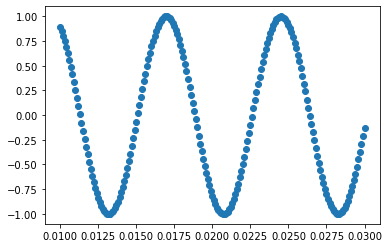

In [5]:
%matplotlib inline
plt.scatter(pdata.loc[0:300,(0,'xx')],pdata.loc[0:300,(0,'yy')])

Split the dataset into training and testing sets

In [6]:
train_dataset = pdata.sample(frac=0.8, random_state=0)
test_dataset = pdata.drop(train_dataset.index)

Split features from labels

In [7]:
train_labels = train_dataset.pop(0)
test_labels = test_dataset.pop(0)

##### Create a model

In [8]:
def build_model():
    model = keras.Sequential([
        layers.Dense(500, activation='relu', input_shape=[len(train_dataset.keys())]),
        layers.Dense(500, activation='relu'),
        layers.Dense(nCoords)
    ])

    model.compile(loss='mse',
                optimizer='adam',
                metrics=['accuracy'])
    return model

In [9]:
model = build_model()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [10]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 500)               100500    
_________________________________________________________________
dense_1 (Dense)              (None, 500)               250500    
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 1002      
Total params: 352,002
Trainable params: 352,002
Non-trainable params: 0
_________________________________________________________________


#### Train the model

In [11]:
history = model.fit(train_dataset, train_labels, validation_split=0.2, epochs=16)

Train on 6336 samples, validate on 1584 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/16
6336/6336 [==============================] - 3s 421us/sample - loss: 0.0122 - acc: 0.9757 - val_loss: 1.8701e-05 - val_acc: 0.9956
Epoch 2/16
6336/6336 [==============================] - 2s 347us/sample - loss: 1.1209e-05 - acc: 0.9984 - val_loss: 7.1874e-06 - val_acc: 0.9987
Epoch 3/16
6336/6336 [==============================] - 2s 327us/sample - loss: 6.4291e-06 - acc: 0.9991 - val_loss: 4.6541e-06 - val_acc: 0.9994
Epoch 4/16
6336/6336 [==============================] - 2s 332us/sample - loss: 8.9602e-06 - acc: 0.9986 - val_loss: 1.1497e-05 - val_acc: 0.9975
Epoch 5/16
6336/6336 [==============================] - 2s 324us/sample - loss: 1.2654e-04 - acc: 0.9931 - val_loss: 3.7405e-04 - val_acc: 0.9848
Epoch 6/16
6336/6336 [==============================] - 2s 327us/sample - loss: 1.5490e-04 - acc: 0.9932 - val_loss: 2.2471e-05 - val_acc: 0.9962
Epoch 7/16
6336/6336 [==========

Visualize the model's training progress via the history object

In [12]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,acc,val_loss,val_acc,epoch
11,0.000036,0.997633,0.000062,0.995581,11
12,0.000511,0.991951,0.000087,0.994950,12
13,0.000053,0.996370,0.000006,0.998106,13
14,0.000005,0.998895,0.000004,0.998737,14
15,0.000020,0.998106,0.000082,0.993687,15


## Basic regression: predict future values of the sine function

#### Predict with the model

If you trained on `n` points (eg. `n = 49`), now predict the value of point `n+1`

Once you have predicted a single future point, develop a 'rolling' predictor which drops the first point and predicts point `n+2` based on the set of points `[2,n+1]`.

Examine the quality of the results for the mechanism to predict points into the future.

____

#### Plot the history

Text(0.5, 1.0, 'model loss')

Text(0, 0.5, 'loss')

Text(0.5, 0, 'epoch')

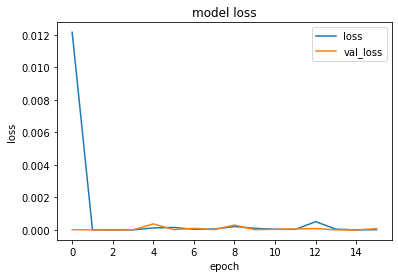

In [13]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss','val_loss'],loc='upper right')
plt.show()

Are `10` epochs too few? If so, try training for more epochs.

In [14]:
# test_predictions = model.predict(test_dataset) #.flatten()

### Make predictions

Finally, predict values using data in the test set:

State,xx,yy
100,0.0100,0.887294
113,0.0113,0.008111
121,0.0121,-0.611975
125,0.0125,-0.837061
126,0.0126,-0.879696
...,...,...
9964,0.9964,0.815083
9970,0.9970,0.993055
9973,0.9973,0.991291
9983,0.9983,0.569080


array([[ 0.0021699 ,  0.8890948 ],
       [ 0.01705395, -0.00750965],
       [ 0.00992835, -0.60677636],
       ...,
       [ 1.0064675 ,  0.9907946 ],
       [ 1.0178162 ,  0.55509555],
       [ 1.0136038 , -0.38992405]], dtype=float32)

Text(0.5, 0, 'True Values')

Text(0, 0.5, 'Predictions')

(-2.0, 2.0)

(-2.0, 2.0)

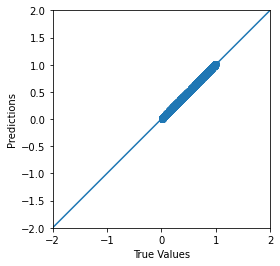

In [15]:
test_predictions = model.predict(test_dataset) #.flatten()

test_labels
test_predictions

a = plt.axes(aspect='equal')
plt.scatter(test_labels['xx'], test_predictions[:,0])
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.xlim([-2,2])
plt.ylim([-2,2])
_ = plt.plot([-2,2], [-2,2])

array([[ 0.0021699 ,  0.8890948 ],
       [ 0.01705395, -0.00750965],
       [ 0.00992835, -0.60677636],
       ...,
       [ 1.0064675 ,  0.9907946 ],
       [ 1.0178162 ,  0.55509555],
       [ 1.0136038 , -0.38992405]], dtype=float32)

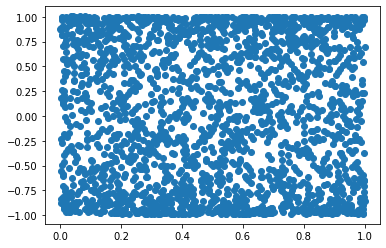

In [16]:
%matplotlib qt
test_predictions
plt.scatter(((T*test_predictions[:,0])%T)/T,test_predictions[:,1])

Take a look at the error distribution.

(array([ 14.,  33.,  38.,  55.,  65.,  34.,  47.,  94., 105., 102., 162.,
        178., 182., 138., 204., 201., 146.,  66.,  33.,  44.,  16.,  11.,
         10.,   1.,   1.]),
 array([-0.02326716, -0.02104027, -0.01881339, -0.0165865 , -0.01435962,
        -0.01213273, -0.00990584, -0.00767896, -0.00545207, -0.00322519,
        -0.0009983 ,  0.00122858,  0.00345547,  0.00568236,  0.00790924,
         0.01013613,  0.01236301,  0.0145899 ,  0.01681678,  0.01904367,
         0.02127056,  0.02349744,  0.02572433,  0.02795121,  0.0301781 ,
         0.03240499]),
 <a list of 25 Patch objects>)

Text(0.5, 0, 'Prediction Error')

(array([  1.,   1.,   1.,   5.,  17.,  14.,  27.,  70.,  90.,  92., 119.,
        196., 166., 186., 137., 255., 260., 122.,  50.,  48.,  19.,  32.,
         43.,  19.,  10.]),
 array([-0.01974278, -0.01799916, -0.01625553, -0.01451191, -0.01276829,
        -0.01102467, -0.00928105, -0.00753742, -0.0057938 , -0.00405018,
        -0.00230656, -0.00056293,  0.00118069,  0.00292431,  0.00466793,
         0.00641156,  0.00815518,  0.0098988 ,  0.01164242,  0.01338605,
         0.01512967,  0.01687329,  0.01861691,  0.02036054,  0.02210416,
         0.02384778]),
 <a list of 25 Patch objects>)

Text(0.5, 0, 'Prediction Error')

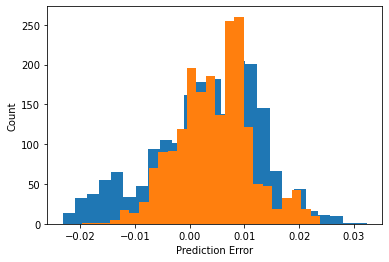

In [17]:
error = test_predictions[:,1] - test_labels['yy']
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error")
_ = plt.ylabel("Count")

error = test_predictions[:,0] - test_labels['xx']
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error")
_ = plt.ylabel("Count")

In [18]:
nMax = 250

data = []
for x in np.arange(0,nMax):
    if x<nPast:
        y = A*np.sin(float(x)*(2*np.pi)/T)
        x = x/nPoints
    else:
        y = 0
        x = 0
    data.append([x,y])
data = np.array(data)

past = data[0:int(nPast),:]
past = np.reshape(past,(1, nCoords*nPast),order='C')

test = pd.DataFrame(past, columns=index)
test.loc[0,('now','xx')] = 0
test.loc[0,('now','yy')] = 0

for i in np.arange(0,int(nMax-nPast)):
    test.loc[i,('now','xx')] = model.predict(test.iloc[i:i+1,:].drop('now',axis=1))[0,0]
    test.loc[i,('now','yy')] = model.predict(test.iloc[i:i+1,:].drop('now',axis=1))[0,1]
    if i != int(nMax-nPast-1):
        test.loc[i+1,-nPast:-1] = test.iloc[i,:].shift(-nCoords)
test

Past       -100                 -99                 -98                 -97  \
State        xx        yy        xx        yy        xx        yy        xx   
0      0.000000  0.000000  0.000100  0.083237  0.000200  0.165896  0.000300   
1      0.000100  0.083237  0.000200  0.165896  0.000300  0.247404  0.000400   
2      0.000200  0.165896  0.000300  0.247404  0.000400  0.327195  0.000500   
3      0.000300  0.247404  0.000400  0.327195  0.000500  0.404715  0.000600   
4      0.000400  0.327195  0.000500  0.404715  0.000600  0.479426  0.000700   
..          ...       ...       ...       ...       ...       ...       ...   
145    0.001906 -0.425536 -0.002890 -0.349517 -0.006980 -0.267208 -0.005517   
146   -0.002890 -0.349517 -0.006980 -0.267208 -0.005517 -0.192961 -0.004655   
147   -0.006980 -0.267208 -0.005517 -0.192961 -0.004655 -0.114738 -0.000986   
148   -0.005517 -0.192961 -0.004655 -0.114738 -0.000986 -0.035013  0.000407   
149   -0.004655 -0.114738 -0.000986 -0.035013  0.000407  0.044002  0.006503   

Past                  -96            ...        -4                  -3  \
State        yy        xx        yy  ...        xx        yy        xx   
0      0.247404  0.000400  0.327195  ...  0.009600  0.989358  0.009700   
1      0.327195  0.000500  0.404715  ...  0.009700  0.973814  0.009800   
2      0.404715  0.000600  0.479426  ...  0.009800  0.951511  0.009900   
3      0.479426  0.000700  0.550809  ...  0.009900  0.922604  0.002170   
4      0.550809  0.000800  0.618370  ...  0.002170  0.889095  0.005296   
..          ...       ...       ...  ...       ...       ...       ...   
145   -0.192961 -0.004655 -0.114738  ... -0.002950  0.937159 -0.002446   
146   -0.114738 -0.000986 -0.035013  ... -0.002446  0.957418 -0.001742   
147   -0.035013  0.000407  0.044002  ... -0.001742  0.969700 -0.001582   
148    0.044002  0.006503  0.128835  ... -0.001582  0.975245 -0.002651   
149    0.128835  0.004154  0.208450  ... -0.002651  0.975987 -0.003886   

Past                   -2                  -1                 now            
State        yy        xx        yy        xx        yy        xx        yy  
0      0.973814  0.009800  0.951511  0.009900  0.922604  0.002170  0.889095  
1      0.951511  0.009900  0.922604  0.002170  0.889095  0.005296  0.847313  
2      0.922604  0.002170  0.889095  0.005296  0.847313  0.008771  0.800230  
3      0.889095  0.005296  0.847313  0.008771  0.800230  0.012055  0.747439  
4      0.847313  0.008771  0.800230  0.012055  0.747439  0.013094  0.686739  
..          ...       ...       ...       ...       ...       ...       ...  
145    0.957418 -0.001742  0.969700 -0.001582  0.975245 -0.002651  0.975987  
146    0.969700 -0.001582  0.975245 -0.002651  0.975987 -0.003886  0.970542  
147    0.975245 -0.002651  0.975987 -0.003886  0.970542 -0.002481  0.959043  
148    0.975987 -0.003886  0.970542 -0.002481  0.959043 -0.001390  0.939601  
149    0.970542 -0.002481  0.959043 -0.001390  0.939601 -0.002599  0.912022  

[150 rows x 202 columns]

In [19]:
test[('now','yy')]

%matplotlib qt
plt.scatter(test[('now','xx')],test[('now','yy')])

0      0.889095
1      0.847313
2      0.800230
3      0.747439
4      0.686739
         ...   
145    0.975987
146    0.970542
147    0.959043
148    0.939601
149    0.912022
Name: (now, yy), Length: 150, dtype: float64

____

## Questions to consider

* How well does your ANN predict beyond the range of data it was trained on?

See the Phase 1 assignment description for additional guidance.

____

## Copyright & license details